In [16]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from epuc.helpers import SineRegressionDataset, sine_fct_prediction
from epuc.model import RegressorModel, NIGNN
from epuc.losses_nig import inner_loss_der, outer_loss_der, NegativeLogLikelihoodLoss
from epuc.train import train_model, train_muliple_models_primary_nig
from epuc.sampling import sample_normal_params_from_normal_inverse_gamma, sample_normal_params_from_nig_vectorised

plt.style.use('seaborn-v0_8')

# Synthetic Experiments on the Validity of Deep Evidential Regression fro Uncertainty Estimation

### Simple Regression Setting

In [116]:
# set paraemters
N_ITER = 100
N_EPOCHS = 5000
LR = 0.005
lambda_reg = 0.1
N_SAMPLES = 1000
BATCH_SIZE = 128
LAMBDA_REG = 1.0
# losses 
loss_primary = NegativeLogLikelihoodLoss()
loss_secondary_outer = outer_loss_der(lambda_reg=0.0)
loss_secondary_inner = inner_loss_der(lambda_reg=0.0)

# regularised losses
loss_secondary_inner_reg = inner_loss_der(lambda_reg=LAMBDA_REG)
loss_secondary_outer_reg = outer_loss_der(lambda_reg=LAMBDA_REG)


Toy data: 

In [18]:
dataset_eval = SineRegressionDataset(n_samples=N_SAMPLES, x_max = 0.5, n_samples_2=10,
                                     eps_var=0.03)

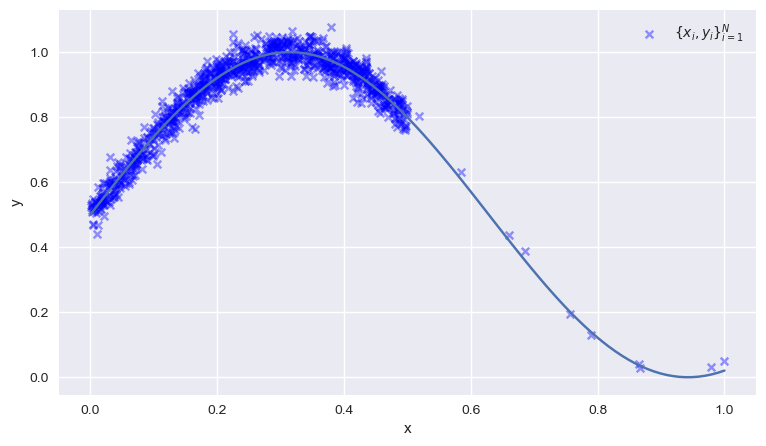

In [4]:
fig, ax = plt.subplots(figsize=(9,5))
x_inst = dataset_eval.x_inst
y_targets = dataset_eval.y_targets

# plot function which generates targets
x = np.linspace(0,1,100)
y = sine_fct_prediction(x, freq=dataset_eval.sine_factor)

ax.set_xlabel("x")
ax.set_ylabel("y")


plt.plot(x,y)
plt.scatter(x_inst, y_targets, s=30, marker="x", color="blue", alpha=0.4, label="$\{x_i, y_i\}_{i=1}^N$")
plt.legend()

In [16]:
# test: train a primary model with Negative Log Likelihood
model = RegressorModel()
dataset = SineRegressionDataset(n_samples=1000, x_max=0.5, n_samples_2=10, eps_var=0.03)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model_out = train_model(model, dataloader=dataloader, criterion=loss_primary, n_epochs=N_EPOCHS, optim=optimizer)


torch.Size([100, 1])


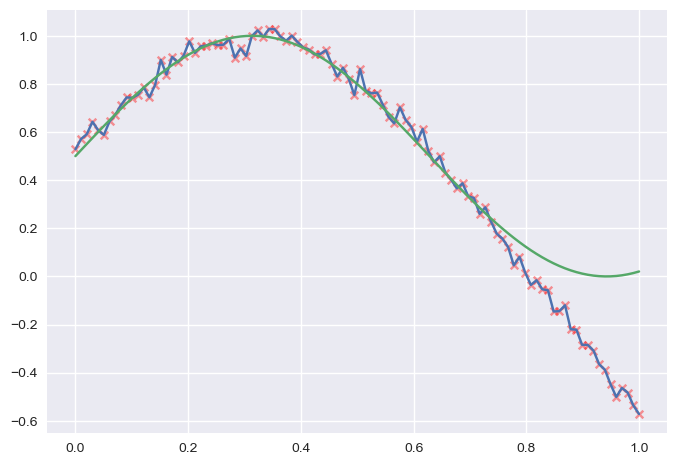

In [17]:
x_eval = np.array(np.linspace(0,1,100))
print(torch.from_numpy(x_eval).reshape(-1,1).shape)
mu, sigma = model_out(torch.from_numpy(x_eval).reshape(-1,1).float())

# sample from induced normal distribution
y_targets = torch.normal(mean=mu, std=sigma)
plt.scatter(x_eval, y_targets.detach().numpy().squeeze(), s=30, marker="x", color="red", alpha=0.4)
plt.plot(x_eval, y_targets.detach().squeeze())
plt.plot(x,y)

In [18]:
results, x_inst = train_muliple_models_primary_nig(dataset=SineRegressionDataset, n_samples=N_SAMPLES,
                                                   n_samples_2=10,
                                                   x_max=0.5, loss=loss_primary, batch_size=BATCH_SIZE,
                                                   eps_var=0.003, lr=LR, n_epochs=N_EPOCHS,
                                                   n_runs=N_ITER)

In [29]:
# calculate confidence bounds for predictions
lower_quantile = np.percentile(results, 2.5, axis=0)
upper_quantile = np.percentile(results, 97.5, axis=0)

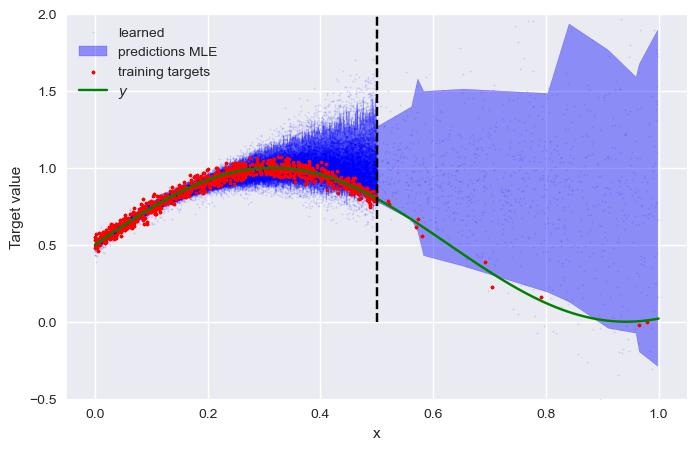

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(x_inst, results, alpha=0.1, s=1, color="blue", label="learned")
ax.fill_between(x_inst[0,:], lower_quantile, upper_quantile, color="blue", alpha=0.4, label="predictions MLE")
ax.scatter(dataset.x_inst.numpy().squeeze(), dataset.y_targets.numpy().squeeze(), s=3, color="red",
           marker="x", label="training targets")
ax.set_ylabel("Target value")
ax.set_xlabel("x")
plt.plot(x,y, color="green", label="$y$")
ax.vlines(0.5, 0, 2, color="black", linestyles="--")
ax.set_ylim(-0.5, 2.0)

plt.legend()

### train with secondary loss optimisation

1. Inner Expectation Minimization

In [117]:
model = NIGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataset = SineRegressionDataset(n_samples=N_SAMPLES, x_max=0.5, n_samples_2=10, eps_var=0.03)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
model_out = train_model(model, dataloader=dataloader, criterion=loss_secondary_outer_reg, n_epochs=N_EPOCHS, optim=optimizer)

In [118]:
# evaluate model on evaluation data
x_eval = np.array(np.linspace(0, 1, 100))
gamma, nu, alpha, beta = model_out(torch.from_numpy(x_eval).reshape(-1, 1).float())


In [119]:
# calculate prediction, epistemic and aleatoric uncertainty
pred = gamma
epistemic_uc = beta/(nu*(alpha-1))
aleatoric_uc = beta/(alpha - 1)

# caluclate upper and lower bounds for the prediction using the epistemic uncertainty
lower_bound = pred - aleatoric_uc
upper_bound = pred + aleatoric_uc

#### Plot predictions from the learned normal-inverse gamma distribution

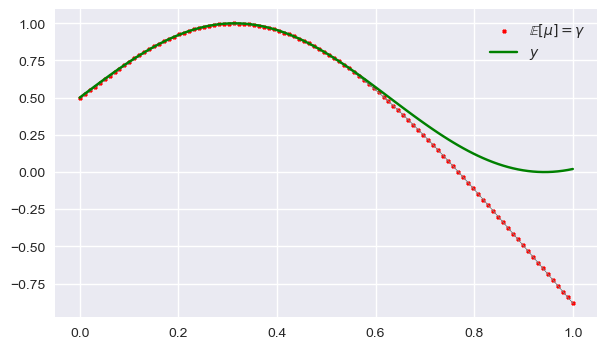

In [120]:
fig, ax = plt.subplots(figsize=(7,4))

ax.scatter(x_eval, gamma.detach().numpy().squeeze(), s=5, marker="x", color="red", alpha=1, label="$\mathbb{E}[\mu] = \gamma $")
plt.fill_between(x, lower_bound.detach().numpy().squeeze(), upper_bound.detach().numpy().squeeze(), color='gray', alpha=1)
plt.plot(x,y, color="green", label="$y$")
plt.legend()

2. Outer Expectation Minimization:

In [127]:
model = NIGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataset = SineRegressionDataset(n_samples=N_SAMPLES, x_max=0.5, n_samples_2=10, eps_var=0.01)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
model_out = train_model(model, dataloader=dataloader, criterion=loss_secondary_outer_reg, n_epochs=N_EPOCHS, optim=optimizer)

In [135]:
gamma, nu, alpha, beta = model_out(torch.from_numpy(x_eval).reshape(-1, 1).float())
pred = gamma
epistemic_uc = beta/(nu*(alpha-1))
aleatoric_uc = beta/(alpha - 1)

# caluclate upper and lower bounds for the prediction using the epistemic uncertainty
lower_bound = pred - epistemic_uc
upper_bound = pred + epistemic_uc

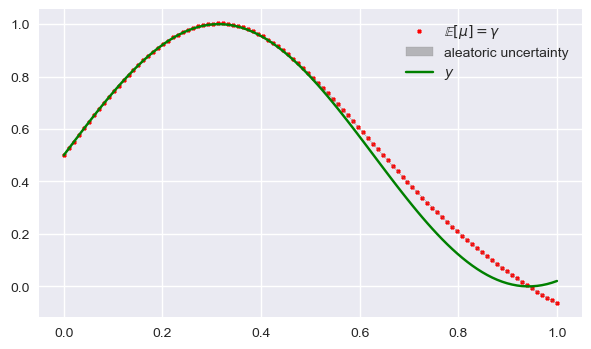

In [129]:
fig, ax = plt.subplots(figsize=(7,4))

ax.scatter(x_eval, pred.detach().numpy().squeeze(), s=5, marker="x", color="red", alpha=1, label="$\mathbb{E}[\mu] = \gamma $")
plt.fill_between(x, lower_bound.detach().numpy().squeeze(), upper_bound.detach().numpy().squeeze(), color='gray', alpha=0.5, 
                label="aleatoric uncertainty")
plt.plot(x,y, color="green", label="$y$")
plt.legend()